In [1]:
import numpy as np
from scipy.constants import e, m_p, m_e, c, epsilon_0, m_n, k as kb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle
import scipy.ndimage as snd

plt.rcParams.update({
    # Color cycle
    "axes.prop_cycle": cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']),

    # Figure size
    "figure.figsize": (4, 3),

    # X ticks
    "xtick.direction": "in",
    "xtick.major.size": 3,
    "xtick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.visible": True,
    "xtick.top": True,

    # Y ticks
    "ytick.direction": "in",
    "ytick.major.size": 3,
    "ytick.major.width": 0.5,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.visible": True,
    "ytick.right": True,

    # Axes & lines
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 1.0,

    # Font & math
    "font.family": "sans-serif",
    #"mathtext.fontset": "dejavuserif",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",

    # Legend & saving
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})


# Generate some synthetic data and see if the code is doing what it should

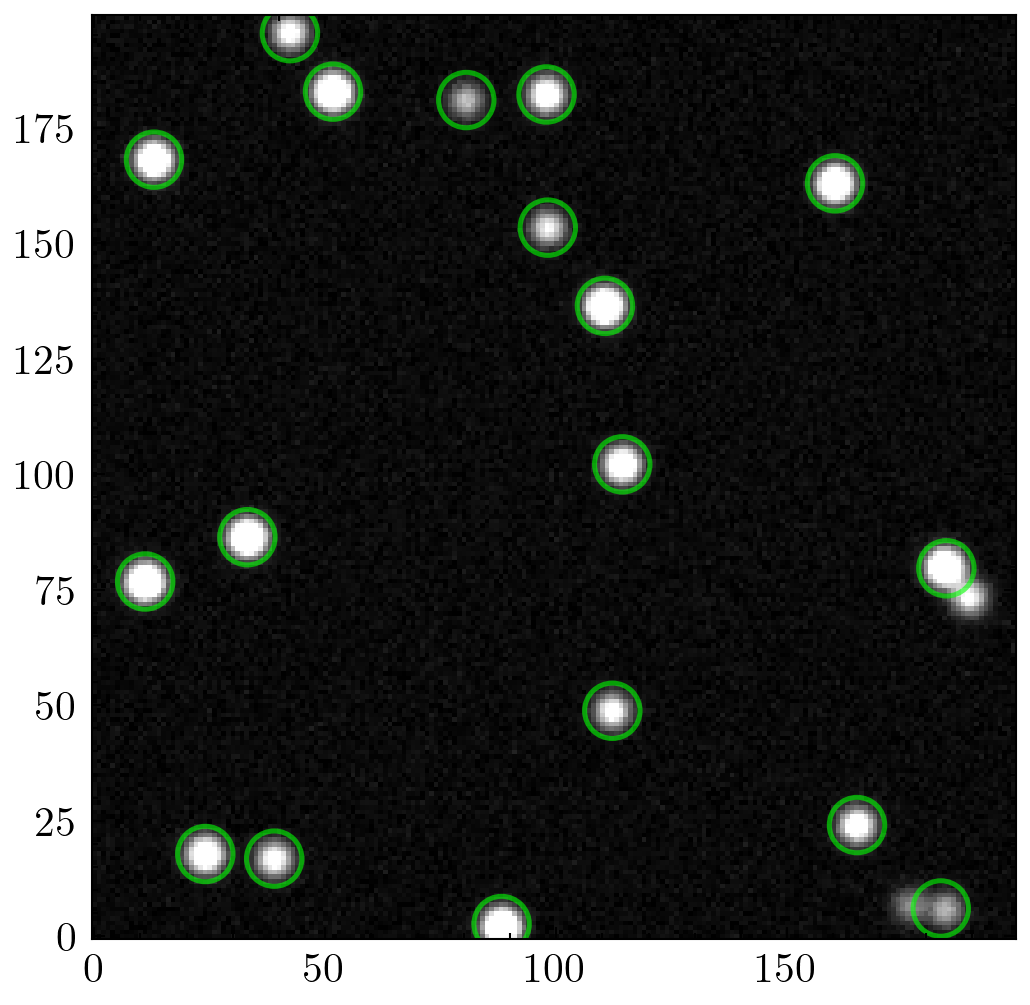

     xcenter            ycenter           true_count    
------------------ ------------------ ------------------
  88.1950484380969 2.6349027036682555  16081.71532819925
183.25540179714858  5.997374246486279   5988.57639729642
 38.97345044616827   16.7866524694591  8842.645971325735
24.063122669666356 17.789861882637236 13228.138830459764
165.12021625631274 24.058330307589706 11014.591081378807
112.15835584296492 48.794698573844734  9326.008581781105
11.049664155322567  76.76801247510471  18774.31863337112
 184.4588825148766  79.63327752162111 17752.681717186584
 33.17674105487597  86.36710600307367 18606.874809965084
114.30606344566593 102.13292340226387 13832.802659847468
110.55509494135285 136.43649822601037 18572.659763384218
 98.19108725528994 153.36925607557197  7721.640619848418
160.36649595799804 162.96356081326243  16398.29768833224
 12.95828554109417 168.08167916463864 16322.876570650522
   80.543237767681 180.98503162560257  5718.511475692663
 97.91366910554014  182.1969881

In [20]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from astropy.modeling.models import Gaussian2D

# --- synthetic image setup ---
ny, nx = 200, 200
y, x = np.mgrid[0:ny, 0:nx]

rng = np.random.default_rng(42)
background = rng.normal(1000, 5, (ny, nx))

# --- multiple Gaussian sources ---
N = 20
sigma = 12 / (2.355) / 2
img = background.copy()

for _ in range(N):
    amp = rng.uniform(100, 500)
    x0, y0 = rng.uniform(0, nx), rng.uniform(0, ny)
    img += Gaussian2D(amp, x0, y0, sigma, sigma)(x, y)

mask = np.ones_like(img, dtype=bool)

# --- detection and photometry ---
mean, median, std = sigma_clipped_stats(img, sigma=3.0, mask=~mask)
daofind = DAOStarFinder(fwhm=12, threshold=4.0 * std)
sources = daofind(img - median, mask=~mask)

if sources is None or len(sources) == 0:
    print("No sources found.")
else:
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    r_aperture = 6
    apertures = CircularAperture(positions, r=r_aperture)
    annuli = CircularAnnulus(positions, r_in=1.5 * r_aperture, r_out=2 * r_aperture)

    aperstats = ApertureStats(img, annuli, mask=~mask)
    bkg_mean = aperstats.mean
    aperture_area = apertures.area_overlap(img, mask=~mask)
    total_bkg = bkg_mean * aperture_area

    phot_table = aperture_photometry(img, apertures, mask=~mask)
    phot_table['total_bkg'] = total_bkg
    phot_table['true_count'] = phot_table['aperture_sum'] - phot_table['total_bkg']

    plt.figure(figsize=(4, 4), dpi=300)
    plt.imshow(img, cmap='gray', origin='lower', 
               vmin=np.percentile(img, 5), vmax=np.percentile(img, 99))
    apertures.plot(color='lime', lw=1.2, alpha=0.6)
    plt.show()

    print(phot_table['xcenter', 'ycenter', 'true_count'])
